# <span style="color:blue">Desafío 2 - Segmentación de Clientes</span>

### <span style="color:orange">Importación de librerías</span>

In [203]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import datetime as dt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### <span style="color:orange">Carga y análisis de calidad de datos</span>

In [204]:
# Carga de datos
data = pd.read_excel("/Users/andrea/Desktop/DATA SCIENCE/Modulo 5-ML/aprendizaje no supervisado I/Desafío/Retail_Invoices.xlsx")

# Vista preliminar de los datos
data_head = data.head()

data_head

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [205]:
def analizar_y_limpiar_datos(data, columnas_negativas=['Quantity', 'price_total']):
    """
    Función para realizar un análisis preliminar de los datos, identificar valores negativos
    en columnas específicas y limpiar los datos.

    Parámetros:
        data (DataFrame): El DataFrame a analizar y limpiar.
        columnas_negativas (list): Lista de columnas en las que se buscarán valores negativos.

    Retorna:
        tuple: (data_info, data_summary, data_cleaned, numeric_summary, negative_values)
    """
    # Vista preliminar de los datos
    data_info = data.info()

    # Seleccionar solo columnas numéricas
    numeric_data = data.select_dtypes(include=[np.number])
    data_summary = numeric_data.describe()

    # Identificar valores negativos en las columnas especificadas
    negative_values = data[(data[columnas_negativas[0]] < 0) | (data[columnas_negativas[1]] < 0)]

    # Filtrar datos para eliminar registros con valores negativos
    data_cleaned = data[(data[columnas_negativas[0]] > 0) & (data[columnas_negativas[1]] > 0)]

    # Resumen después de limpieza, considerando solo columnas numéricas
    numeric_summary = data_cleaned.select_dtypes(include=[np.number]).describe()

    return data_info, data_summary, data_cleaned, numeric_summary, negative_values

# Uso de la función
data_info, data_summary, data_cleaned, numeric_summary, negative_values = analizar_y_limpiar_datos(data)

# Imprimir resultados
print(data_cleaned)
print("\nResumen después de limpieza:\n", numeric_summary)
print("\nValores negativos detectados:\n", negative_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB
      InvoiceNo InvoiceDate  CustomerID  Quantity  price_total  StockCode
0        536365  2010-12-01       17850        40       139.12          7
1        536366  2010-12-01       17850        12        22.20          2
2        536367  2010-12-01       13047        83       278.73         12
3        536368  2010-12-01       13047        15        70.05          4
4        536369  2010-12-01       13047         3

### <span style="color:purple">Análisis de los Datos:</span>

1. **Estructura General**
    - **Total de registros**: 22,190.
    - **Columnas**: 6.
    - **Tipos de datos**:
        - InvoiceNo: Identificador de la factura, tipo object.
        - InvoiceDate: Fecha de la factura, tipo datetime64[ns].
        - CustomerID: Identificador del cliente, tipo int64.
        - Quantity: Cantidad de productos, tipo int64.
        - price_total: Total facturado, tipo float64.
        - StockCode: Código de producto, tipo int64.


2. **Problemas Detectados**

   - **Valores Negativos:** Se detectaron valores negativos en las columnas Quantity y price_total.
       - **Cantidad de valores negativos**: 3,654 registros presentan valores negativos, probablemente debido a devoluciones.
       - **Impacto:** Los valores negativos afectan el análisis financiero agregado, ya que los totales y promedios se distorsionan.

    - **Desviaciones Estándar Altas:** Tanto en Quantity como en price_total, las desviaciones estándar son altas, lo que indica la presencia de outliers o valores extremos.

    - **StockCode como Categórico:** Aunque StockCode es numérico, parece corresponder a un identificador de productos, por lo que podría ser tratado como categórico.


### <span style="color:purple">Análisis de los Datos Limpiados:</span>

1. **Estructura General**
    - **Total de registros**: 18,532.
    - **Acciones tomadas:** Se eliminaron los registros con valores negativos en Quantity y price_total.

2. **Estadísticas Descriptivas** 
    
    - **Quantity**
        - **Rango**: 1 a 80,995.
        - **Media**: 278.90.
        - **Desviación estándar**: 972.73.
        - **Percentiles**:
            - 25% de los valores están por debajo de 74 unidades.
            - 50% de las compras son de 155 unidades o menos.
            - 75% de las compras están por debajo de 291 unidades.
        - **Observación**: Aunque los valores negativos han sido eliminados, aún existen valores extremos que podrían analizarse como outliers.

    - **price_total**
        - **Rango**: 0.38 a 168,469.60.
        - **Media**: 480.87.
        - **Desviación estándar**: 1,678.20.
        - **Percentiles:**
            - 25% de las facturas son menores a 158.04.
            - 50% es menor a 303.04.
            - 75% es menor a 471.84.
        - **Observación**: Existen montos muy altos que podrían ser compras grandes realizadas por empresas o distribuidores.

    - **StockCode**
        - **Rango**: 1 a 542.
        - **Media**: 21.47.
        - Corresponde a un identificador numérico para productos.


3. **Observaciones**

    - **Datos Limpiados**: Los valores negativos han sido eliminados.
    - **Distribución Desbalanceada**: Tanto en 'Quantity' como en 'price_total' hay valores extremos significativos (outliers).
    - **Identificación de Clientes**: Los datos son útiles para segmentación por cliente.

4. **Pasos a seguir**
    1. **Análisis de Outliers:** Examinar las compras con valores extremos en Quantity y price_total.
    2. **Segmentación de Clientes:** Aplicar técnica RFM (Recencia, Frecuencia, Monto) para identificar patrones de compra.
    
    

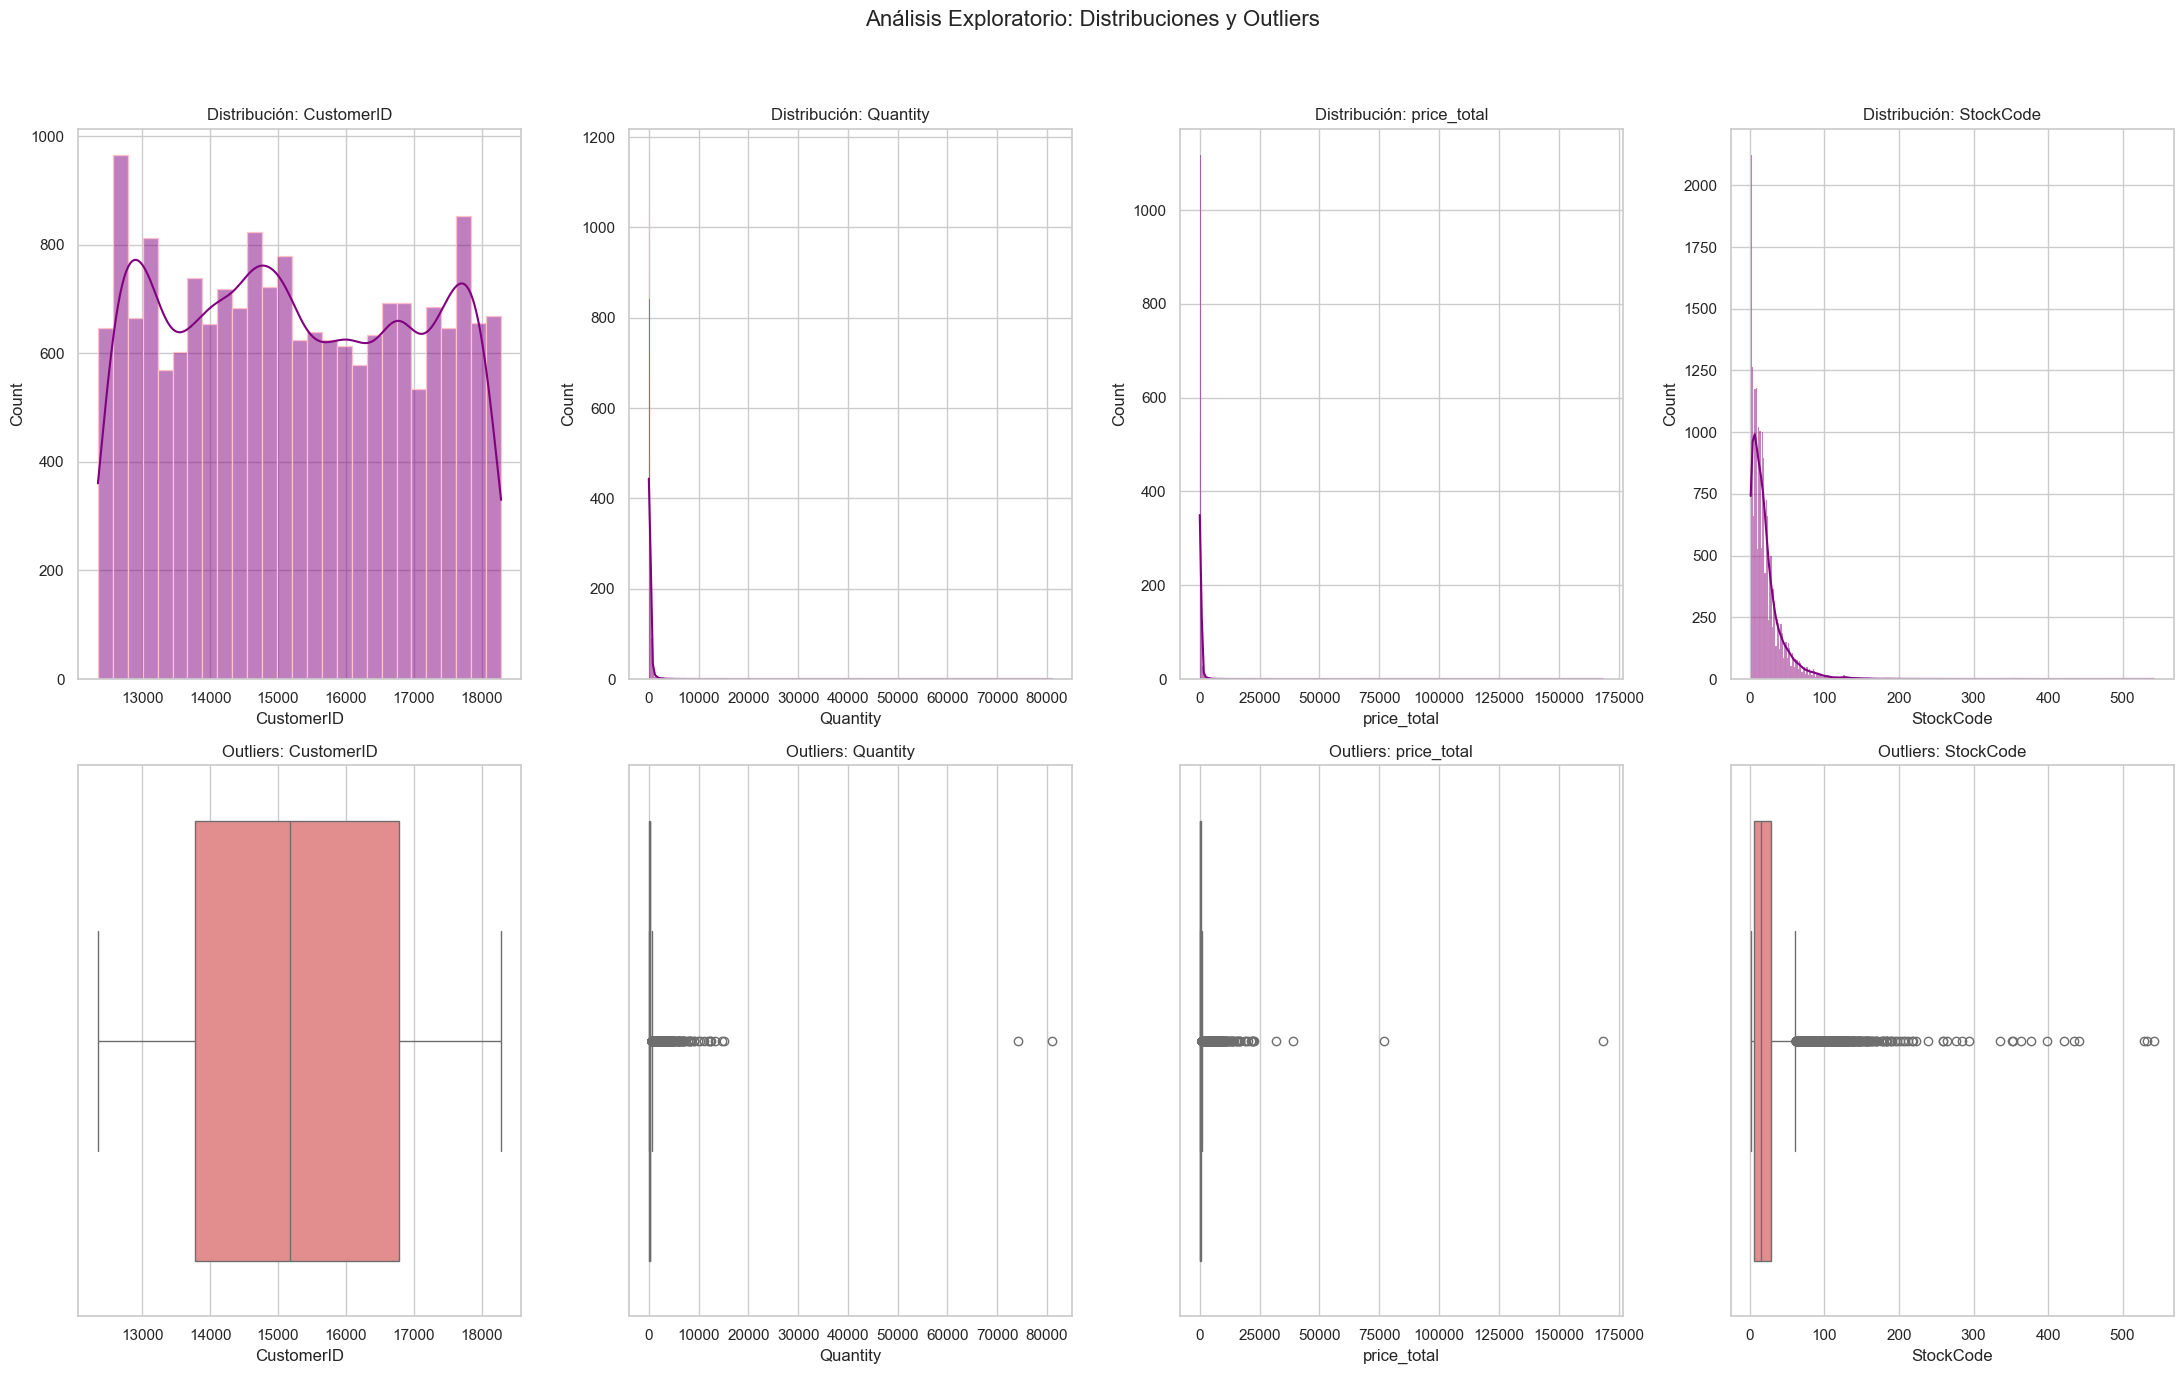

In [206]:
# Filtrar solo columnas numéricas
numeric_data_cleaned = data_cleaned.select_dtypes(include=[np.number])

# Crear subplots para histogramas y boxplots
fig, axes = plt.subplots(2, len(numeric_data_cleaned.columns), figsize=(22, 14))
fig.suptitle('Análisis Exploratorio: Distribuciones y Outliers', fontsize=16)

for i, col in enumerate(numeric_data_cleaned.columns):
    # Histograma
    sns.histplot(numeric_data_cleaned[col], kde=True, ax=axes[0, i], color='purple', edgecolor='pink')
    axes[0, i].set_title(f'Distribución: {col}')
    
    # Boxplot
    sns.boxplot(x=numeric_data_cleaned[col], ax=axes[1, i], color='lightcoral')
    axes[1, i].set_title(f'Outliers: {col}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar espacios
plt.show()



**<span style="color:purple">Análisis Exploratorio: Distribuciones y Outliers</span>**

1. **Distribuciones**
    - **CustomerID:** Distribución uniforme con ligeras fluctuaciones en la frecuencia de los clientes. No se observan patrones claros de concentración en grupos específicos.

    - **Quantity:** Distribución altamente sesgada hacia valores bajos. La mayoría de las compras tienen un volumen pequeño, pero existen algunas compras masivas que representan valores extremos.

    - **price_total:** Similar a 'Quantity', muestra una distribución sesgada hacia la izquierda. La mayoría de las facturas tienen valores bajos, mientras que unas pocas tienen montos muy altos.

    - **StockCode:** Distribución concentrada en un rango estrecho (valores pequeños). Los códigos de productos más altos son mucho menos frecuentes.


2. **Outliers**
    - **Quantity**: Identificación de múltiples valores atípicos con compras extremadamente grandes. Estos valores podrían representar compras excepcionales o errores en los datos.

    - **price_total**:Presencia de facturas con montos significativamente más altos que la mayoría. Estos montos altos están probablemente relacionados con los valores extremos de 'Quantity'.

    - **StockCode:** Aunque el rango de los códigos es amplio, la mayoría de los valores se concentran en un intervalo bajo, con algunos outliers asociados a códigos menos comunes.


3. **Observaciones Clave**
    - Las distribuciones de 'Quantity' y 'price_total' están fuertemente influenciadas por outliers.
    - La mayoría de los valores en estas variables se encuentran en rangos bajos, lo que indica que las compras masivas son excepcionales.
    - 'CustomerID' muestra una distribución uniforme, lo que sugiere una asignación de identificadores aleatoria o bien distribuida.


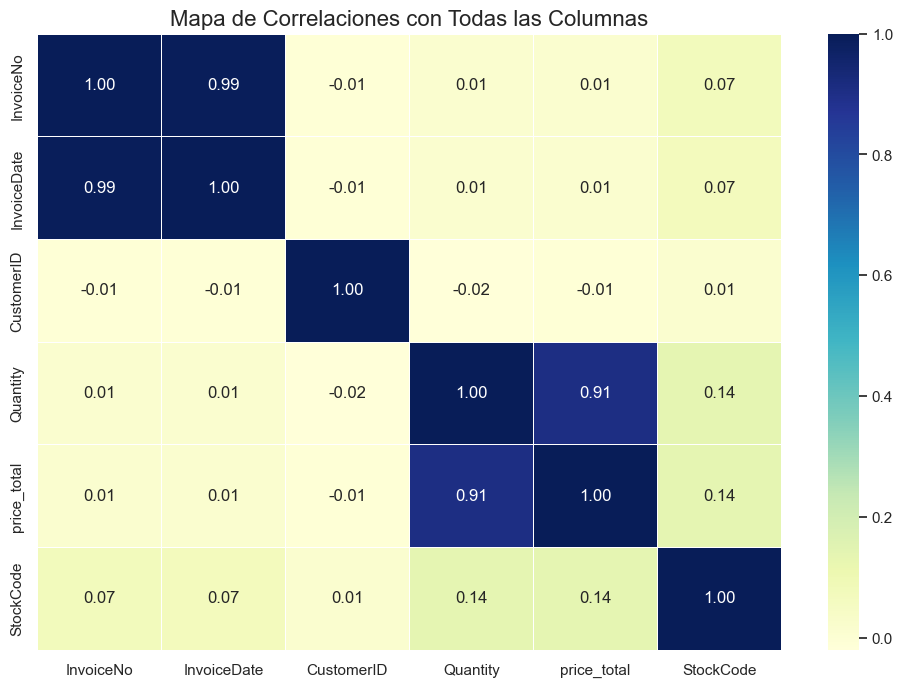

In [207]:
# Transformar todas las columnas no numéricas para incluirlas en el mapa de calor
data_transformed = data_cleaned.copy()

# Convertir columnas categóricas, fechas y Period en valores numéricos
for col in data_transformed.columns:
    if data_transformed[col].dtype == 'object':  # Si es categórica
        data_transformed[col] = data_transformed[col].astype('category').cat.codes
    elif data_transformed[col].dtype == 'datetime64[ns]':  # Si es fecha
        data_transformed[col] = data_transformed[col].astype('int64')  # Convertir a timestamp
    elif str(data_transformed[col].dtype).startswith('period'):  # Si es Period
        data_transformed[col] = data_transformed[col].astype('category').cat.codes

# Calcular la matriz de correlación con todas las columnas
correlation_matrix = data_transformed.corr()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlaciones con Todas las Columnas', fontsize=16)
plt.show()



**<span style="color:purple">Análisis del Mapa de Correlaciones</span>** 

1. **Relación entre Variables**
    - **Quantity y price_total**: Alta correlación positiva (**0.85**). Es coherente, ya que un mayor número de productos adquiridos ('Quantity') generalmente resulta en un mayor total facturado ('price_total').

    - **InvoiceNo y InvoiceDate**: Correlación casi perfecta (**0.99**), lo que sugiere que los números de factura ('InvoiceNo') están estrechamente vinculados al orden cronológico de emisión ('InvoiceDate').

    - **MonthYear y InvoiceDate**: Correlación perfecta (**1.0**). Esto es esperado, ya que 'MonthYear' deriva directamente de 'InvoiceDate'.

2. **Variables con Baja Correlación**
    - **CustomerID con otras variables**: Correlaciones muy bajas con todas las demás columnas, indicando que los clientes no muestran patrones evidentes en relación a la cantidad, el total facturado, o los códigos de producto.

    - **StockCode con Quantity y price_total**: Correlaciones bajas (0.18 y 0.20, respectivamente) que sugiere que los productos específicos ('StockCode') no influyen significativamente en la cantidad comprada ni en el total facturado.

3. **Observaciones**
    - Las correlaciones altas entre variables como 'InvoiceDate', 'InvoiceNo', y 'MonthYear' son esperadas debido a su dependencia lógica.
    - La relación fuerte entre 'Quantity' y 'price_total' valida la consistencia de los datos.


### <span style="color:purple">Análisis y corrección de la columna InvoiceDate</span>

Para analizar la columna InvoiceDate y verificar si tiene errores podemos realizar los siguientes pasos:

- Verificar valores nulos o faltantes.
- Confirmar que todos los valores son válidos y están en el formato de fecha esperado (datetime).
- Analizar el rango de fechas para detectar anomalías.
- Identificar duplicados si corresponden.


In [208]:
# Crear una copia explícita 
data_cleaned = data_cleaned.copy()

# Verificar si hay valores nulos en 'InvoiceDate'
missing_dates = data_cleaned['InvoiceDate'].isnull().sum()
print(f"Valores nulos en 'InvoiceDate': {missing_dates}")

# Verificar el tipo de dato de la columna 'InvoiceDate'
print(f"\nTipo de datos de 'InvoiceDate': {data_cleaned['InvoiceDate'].dtype}")

# Convertir 'InvoiceDate' a datetime 
if data_cleaned['InvoiceDate'].dtype != 'datetime64[ns]':
    data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])
    print("La columna 'InvoiceDate' se convirtió a formato datetime.")

# Crear la columna 'MonthYear'
if 'MonthYear' not in data_cleaned.columns:
    data_cleaned['MonthYear'] = data_cleaned['InvoiceDate'].dt.to_period('M')
    print("La columna 'MonthYear' ha sido creada.")

# Analizar el rango de fechas
min_date = data_cleaned['InvoiceDate'].min()
max_date = data_cleaned['InvoiceDate'].max()
print(f"\nRango de fechas: {min_date} a {max_date}")

# Detectar posibles valores fuera de rango (fechas futuras o inconsistentes)
import datetime
today = datetime.datetime.today()
out_of_range_dates = data_cleaned[data_cleaned['InvoiceDate'] > today]
print(f"\nFechas fuera de rango: {out_of_range_dates.shape[0]}")
if not out_of_range_dates.empty:
    print(out_of_range_dates[['InvoiceNo', 'InvoiceDate']])  # Mostrar registros fuera de rango

# Analizar duplicados en combinación con otras columnas
duplicates = data_cleaned.duplicated(subset=['InvoiceNo', 'InvoiceDate']).sum()
print(f"\nRegistros duplicados basados en 'InvoiceNo' y 'InvoiceDate': {duplicates}")




Valores nulos en 'InvoiceDate': 0

Tipo de datos de 'InvoiceDate': datetime64[ns]
La columna 'MonthYear' ha sido creada.

Rango de fechas: 2010-12-01 00:00:00 a 2011-12-09 00:00:00

Fechas fuera de rango: 0

Registros duplicados basados en 'InvoiceNo' y 'InvoiceDate': 0


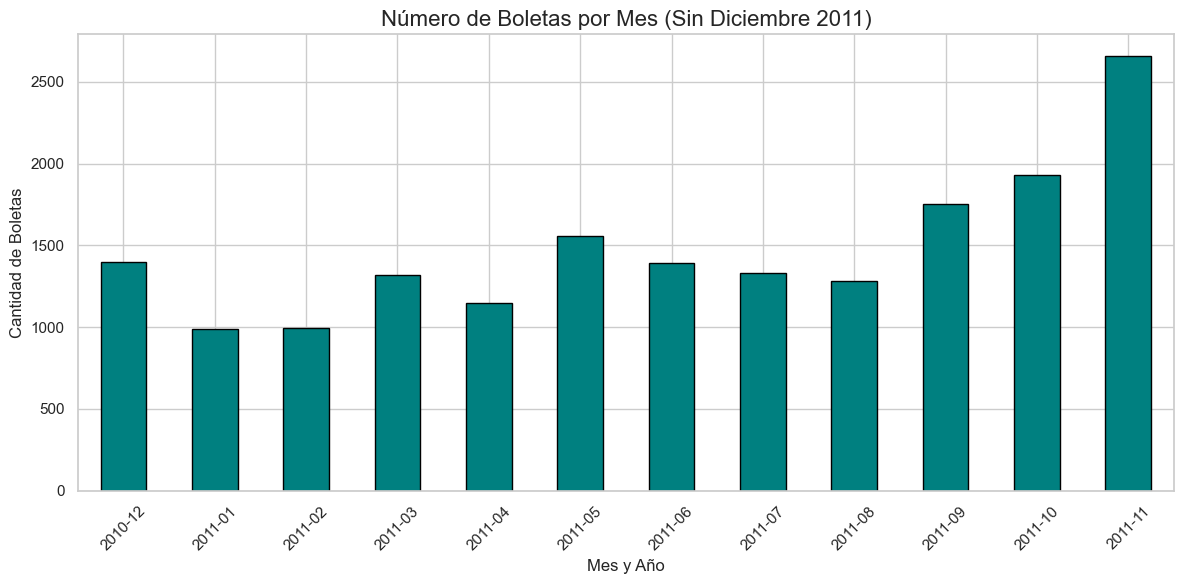

In [209]:
# Creamos un gráfico para relacionar la cantidad de boletas emitidas con la fecha

# Filtrar los datos para excluir diciembre 2011
data_cleaned = data_cleaned[data_cleaned['MonthYear'] != '2011-12']

# Recalcular el número de boletas por mes
invoices_per_month = data_cleaned.groupby('MonthYear')['InvoiceNo'].count()

# Graficar nuevamente el número de boletas por mes sin diciembre 2011
plt.figure(figsize=(12, 6))
invoices_per_month.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Número de Boletas por Mes (Sin Diciembre 2011)', fontsize=16)
plt.xlabel('Mes y Año', fontsize=12)
plt.ylabel('Cantidad de Boletas', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### <span style="color:purple">Observaciones:</span> 
Con esta información podemos observar que el mes de Diciembre de 2011 no esta completo, por lo que no obtenemos un análisis de 12 meses completos.
Podemos ver además que a lo largo del tiempo hay un aumento en la cantidad boletas, siendo esta mayor en los meses de spetiembre a noviembre del año 2011.

### <span style="color:orange">Generar variables de segmentación - Técnica RFM</span>

**Este enfoque se basa en agrupar los datos por cliente y calcular las métricas correspondientes.**

In [210]:
# Crear el DataFrame RFM con las variables de segmentación a nivel cliente
rfm_clientes = data_cleaned.groupby('CustomerID').agg(
    Recencia=('InvoiceDate', lambda x: (reference_date - x.max()).days),  # Días desde la última compra
    Frecuencia=('InvoiceNo', 'nunique'),  # Número de facturas únicas realizadas por cliente
    Monto_Total=('price_total', 'sum'),  # Total gastado por cliente
    Cantidad_Promedio=('Quantity', 'mean'),  # Cantidad promedio de productos por boleta
    Cantidad_Total=('Quantity', 'sum'),  # Cantidad total de productos comprados
    Monto_Promedio=('price_total', 'mean'),  # Gasto promedio por boleta
    Articulos_Distintos=('StockCode', 'nunique')  # Número de códigos de producto distintos comprados
).reset_index()

# Mostrar las primeras filas del DataFrame RFM
rfm_clientes.head()


,CustomerID,Recencia,Frecuencia,Monto_Total,Cantidad_Promedio,Cantidad_Total,Monto_Promedio,Articulos_Distintos
0,12346,316,1,77183.60,74215.000000,74215,77183.600000,1
1,12347,30,6,4085.18,377.666667,2266,680.863333,6
2,12348,66,4,1797.24,585.250000,2341,449.310000,4
3,12349,9,1,1757.55,631.000000,631,1757.550000,1
4,12350,301,1,334.40,197.000000,197,334.400000,1


In [211]:
print(f"Número de clientes únicos: {rfm_clientes['CustomerID'].nunique()}")


Número de clientes únicos: 4297


### <span style="color:orange">Análisis exploratorio y transformaciones</span>

In [212]:
# Generar un resumen estadístico para las variables RFM generadas
resumen_rfm = rfm_clientes.describe()  # Resumen estadístico del DataFrame RFM
resumen_rfm

,CustomerID,Recencia,Frecuencia,Monto_Total,Cantidad_Promedio,Cantidad_Total,Monto_Promedio,Articulos_Distintos
count,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000,4297.000000
mean,15302.648592,90.481499,4.131720,1953.273240,244.655113,1135.943682,400.371478,3.333721
std,1720.900338,98.577826,7.412705,8355.832473,1167.325195,4746.783621,1271.352605,3.827989
min,12346.000000,0.000000,1.000000,2.900000,1.000000,1.000000,2.900000,1.000000
25%,13816.000000,15.000000,1.000000,304.470000,93.000000,157.000000,178.700000,1.000000
50%,15300.000000,49.000000,2.000000,657.300000,161.750000,368.000000,295.056667,2.000000
75%,16781.000000,145.000000,4.000000,1600.860000,273.666667,950.000000,431.674000,4.000000
max,18287.000000,364.000000,200.000000,268478.000000,74215.000000,188957.000000,77183.600000,69.000000


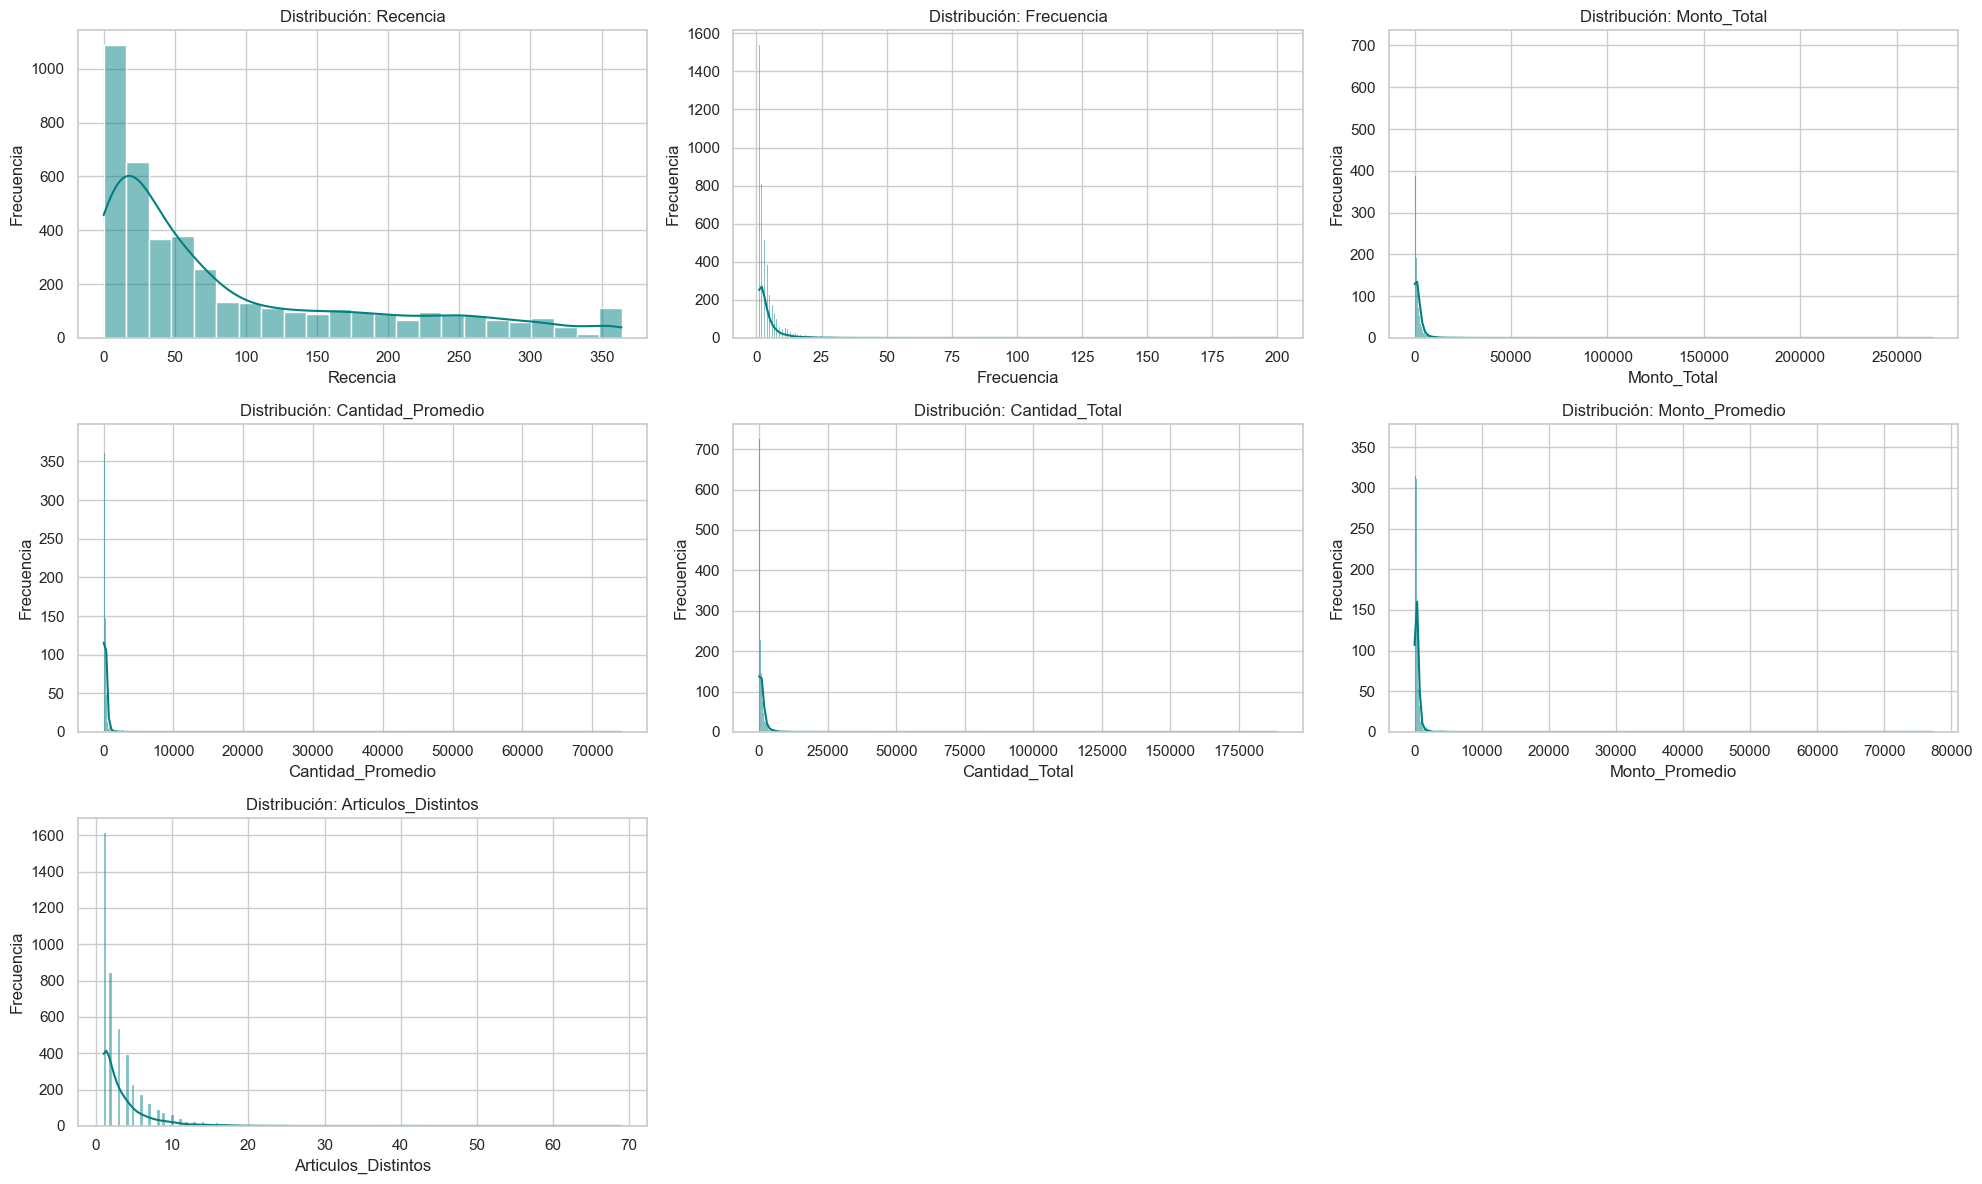

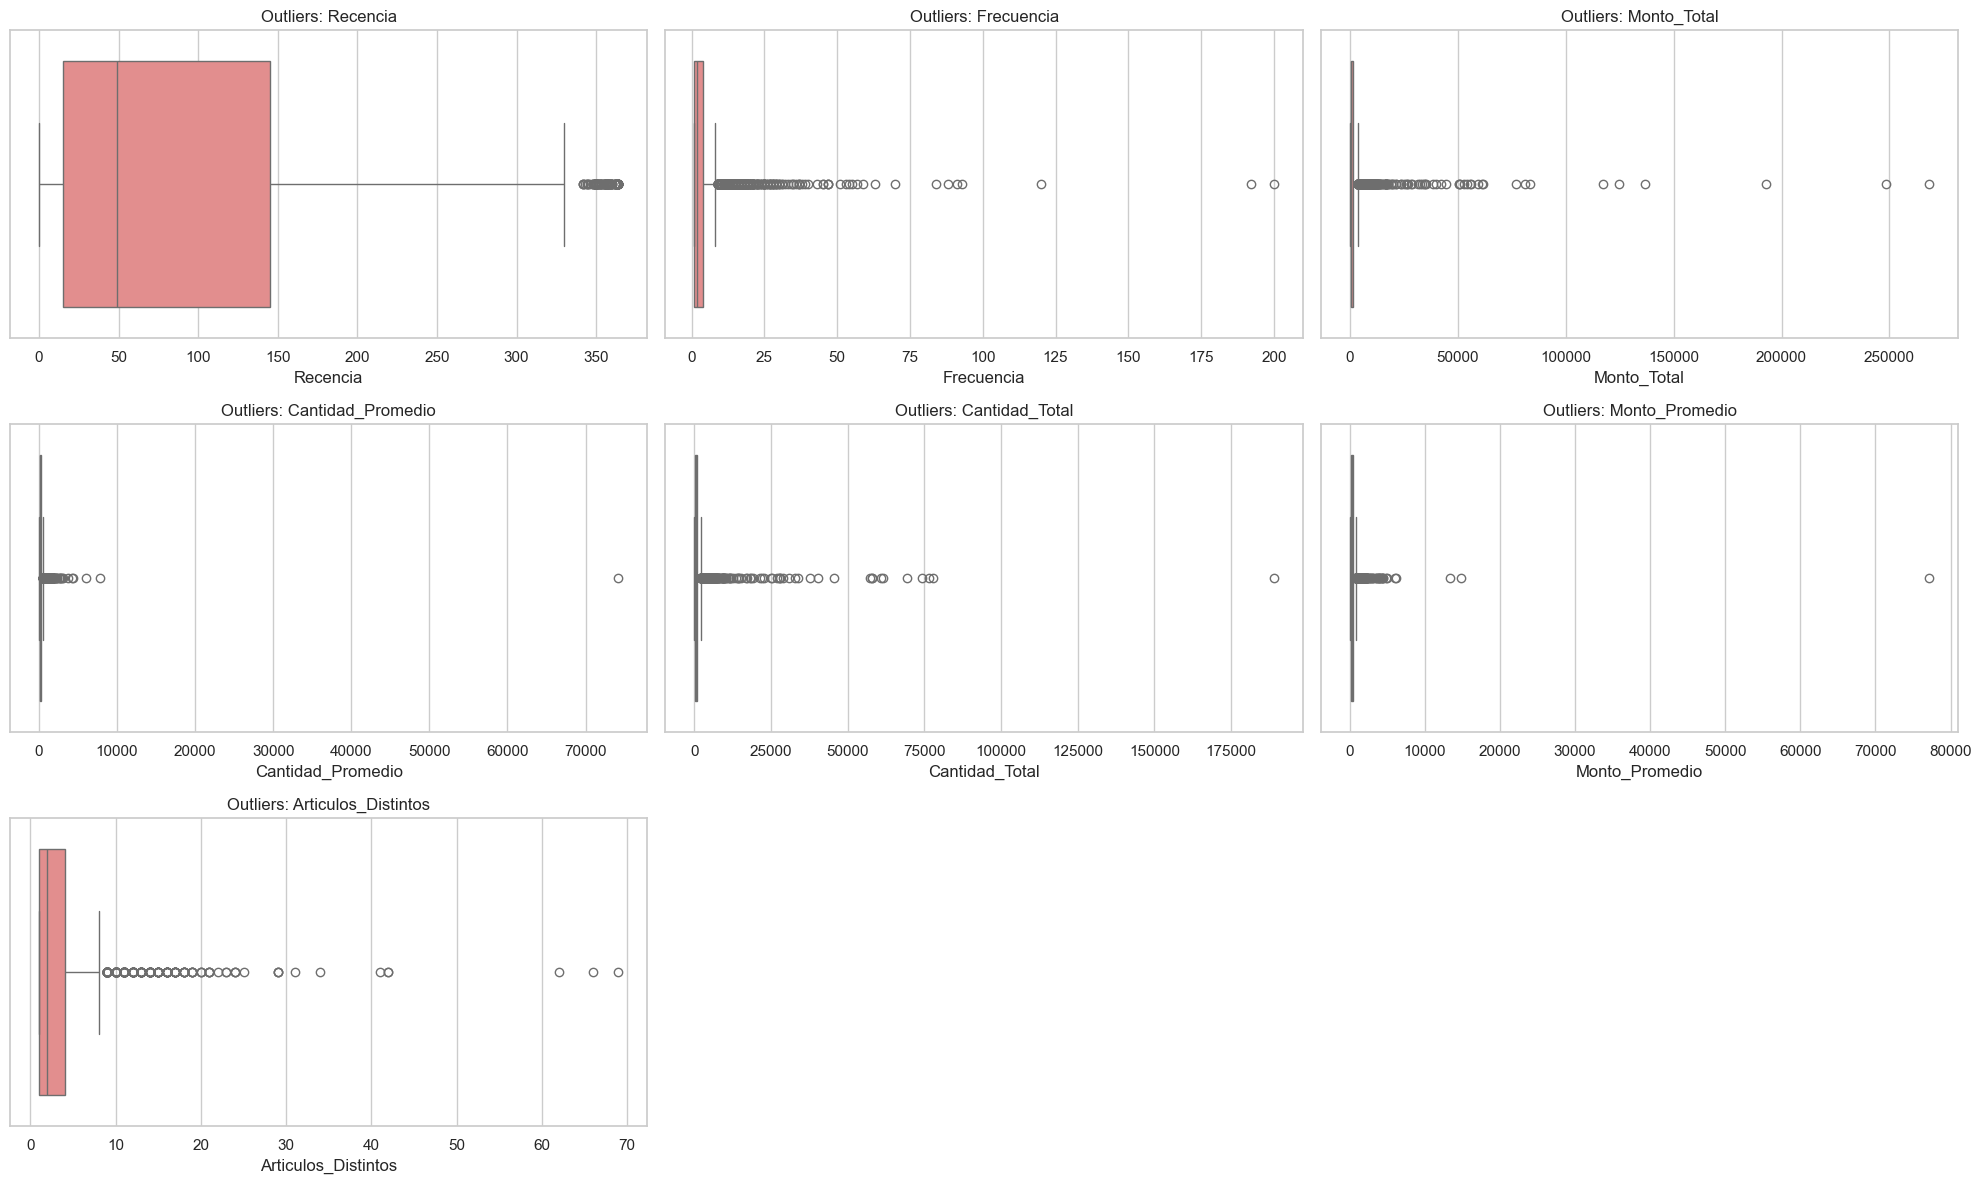

In [213]:
# Generar transformaciones logarítmicas para reducir sesgos
rfm_clientes['Monto_Total_log'] = np.log1p(rfm_clientes['Monto_Total'])
rfm_clientes['Cantidad_Total_log'] = np.log1p(rfm_clientes['Cantidad_Total'])
rfm_clientes['Monto_Promedio_log'] = np.log1p(rfm_clientes['Monto_Promedio'])
rfm_clientes['Frecuencia_log'] = np.log1p(rfm_clientes['Frecuencia'])

# Visualización de las variables originales RFM
plt.figure(figsize=(20, 12))
variables = ['Recencia', 'Frecuencia', 'Monto_Total', 
             'Cantidad_Promedio', 'Cantidad_Total', 
             'Monto_Promedio', 'Articulos_Distintos']

for i, col in enumerate(variables):
    plt.subplot(3, 3, i + 1)  
    sns.histplot(rfm_clientes[col], kde=True, color='teal')  
    plt.title(f'Distribución: {col}')  
    plt.xlabel(col)  
    plt.ylabel('Frecuencia')  

plt.tight_layout()
plt.show()

# Identificación de outliers mediante boxplots
plt.figure(figsize=(20, 12))
for i, col in enumerate(variables):
    plt.subplot(3, 3, i + 1)  
    sns.boxplot(x=rfm_clientes[col], color='lightcoral')  
    plt.title(f'Outliers: {col}')  
    plt.xlabel(col)

plt.tight_layout()
plt.show()



**<span style="color:purple">Análisis</span>** 

1. **Distribución de las Variables Originales**

    - **Recencia:** La mayoría de los clientes realizó su última compra en los primeros 50 días desde la fecha de referencia. Hay una disminución gradual hacia los 300 días, lo que indica que algunos clientes tienen periodos de inactividad muy largos.

    - **Frecuencia:** La mayoría de los clientes realizó solo unas pocas compras, menos de 10 facturas únicas. Existen clientes con valores extremos, llegando a más de 150 compras, lo que podría corresponder a clientes muy frecuentes.

    - **Monto_Total:** La distribución es altamente sesgada hacia la izquierda, con la mayoría de los clientes gastando menos de 50,000. Algunos clientes tienen gastos acumulados muy altos, lo que podría ser indicativo de clientes mayoristas.

    - **Cantidad_Promedio:** La cantidad promedio por boleta está altamente concentrada en valores bajos, menor a 2,000 unidades. Existen casos extremos con valores mucho mayores, probablemente clientes que compran grandes cantidades en una sola transacción.

    - **Cantidad_Total:** Similar a las otras métricas, la mayoría de los clientes acumulan una cantidad total baja de productos (menos de 25,000). Hay valores extremos que indican clientes que han comprado grandes volúmenes a lo largo del tiempo.

    - **Monto_Promedio:** La mayoría de los clientes tienen un monto promedio bajo por factura. Hay algunos valores extremos que sugieren clientes que realizan compras de alto valor.

    - **Artículos_Distintos:** La mayoría de los clientes compraron menos de 10 artículos únicos. Existen clientes que han comprado más de 50 artículos distintos, lo que podría indicar clientes con patrones de compra variados.


2. **Identificación de Outliers mediante Boxplots**

    - **Recencia:** Los outliers corresponden a clientes con periodos de inactividad muy largos, periodos cercanos a los 360 días.

    - **Frecuencia:** La mayoría de los valores se concentran en frecuencias bajas, pero hay outliers con frecuencias superiores a 100.

    - **Monto_Total:** Los clientes con gastos acumulados altos son identificados como outliers.

    - **Cantidad_Promedio y Cantidad_Total:** Ambas métricas presentan outliers que representan clientes con compras significativamente más altas en comparación con el resto.

    - **Monto_Promedio:** Los valores atípicos son evidentes en clientes que tienen gastos promedio mucho más altos.

    - **Artículos_Distintos:** Los outliers son clientes que compraron una gran variedad de artículos.


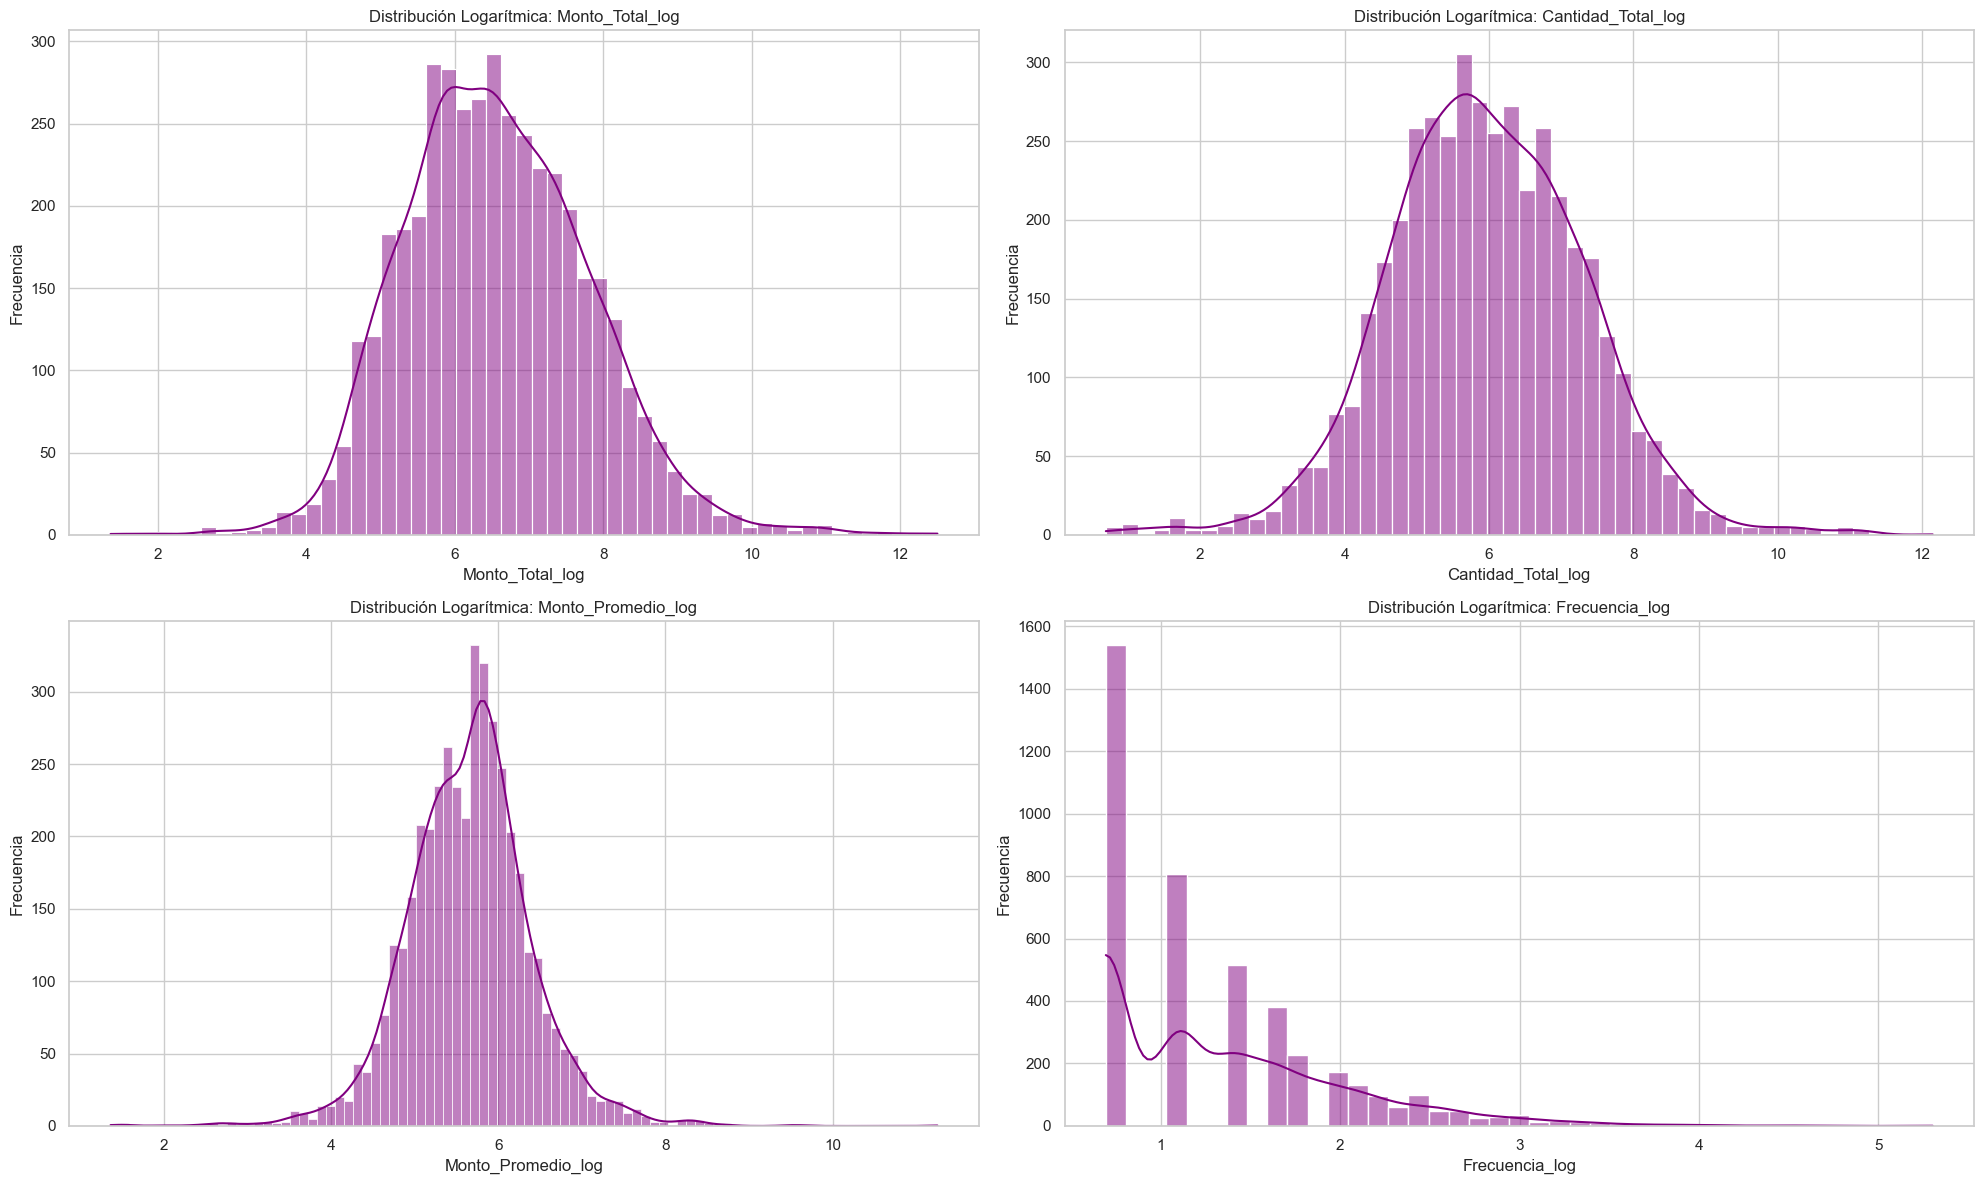

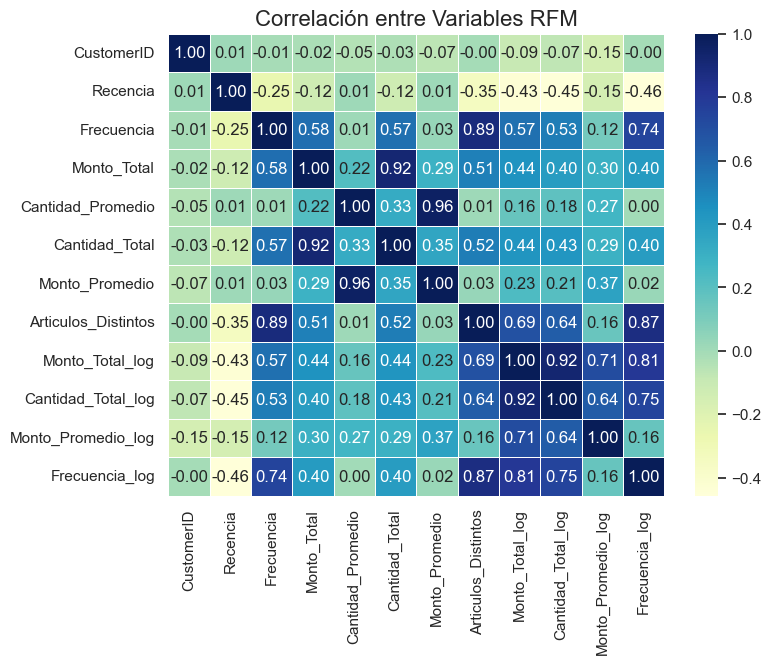

In [214]:
# Visualización de las distribuciones después de transformaciones logarítmicas
plt.figure(figsize=(20, 12))
variables_log = ['Monto_Total_log', 'Cantidad_Total_log', 'Monto_Promedio_log', 'Frecuencia_log']

for i, col in enumerate(variables_log):
    plt.subplot(2, 2, i + 1)  
    sns.histplot(rfm_clientes[col], kde=True, color='purple')  
    plt.title(f'Distribución Logarítmica: {col}') 
    plt.xlabel(col) 
    plt.ylabel('Frecuencia') 

plt.tight_layout()
plt.show()

# Correlación entre las variables RFM
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_clientes.corr(), annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title('Correlación entre Variables RFM', fontsize=16)
plt.show()

**<span style="color:purple">Análisis</span>** 

1. **Distribuciones logarítmicas**

    - **Monto_Total_log:** La transformación logarítmica logró distribuir los valores de forma más simétrica. Esto indica que los outliers en el gasto total fueron mitigados con éxito.

    - **Cantidad_Total_log:** También presenta una distribución más equilibrada tras la transformación logarítmica. Los valores atípicos que se encontraban en los extremos fueron suavizados, permitiendo un análisis más robusto.

    - **Monto_Promedio_log:** La transformación ha dado como resultado una distribución cercana a la normal. Esto facilita el uso de esta variable en algoritmos de clustering.

    - **Frecuencia_log:** Aunque sigue presentando un sesgo leve hacia la izquierda, la transformación logarítmica mejoró significativamente la distribución original, que estaba fuertemente sesgada.

2. **Mapa de correlación**

    - **FrecuenciayMonto_Total (0,58):** Una calificación positiva indica que los clientes que compran con mayor frecuencia tienden a gastar más en total.

    - **Cantidad_TotalyMonto_Total (0,92):** Esta relación es esperada, ya que un mayor volumen de compras generalmente está asociado con un gasto mayor.

    - **Monto_PromedioyMonto_Total (0,29):** Aunque es positiva es más débil, lo que sugiere que el monto promedio no necesariamente predice el gasto total.
    
    - **Frecuencia_logyMonto_Total_log (0,74):** La transformación logarítmica resalta aún más la relación positiva entre la frecuencia y el monto total gastado.

     - **Recenciacon otras variables**: La variable de recencia muestra correlaciones débiles o negativas con las demás variables, lo que indica que los clientes más recientes no necesariamente compran más ni gastan más.

3. **Conclusiones**

    - **Transformaciones logarítmicas:** Han sido efectivas para reducir sesgos y estabilizar las distribuciones de las variables. Esto va a permitir un mejor desempeño en algoritmos de clustering y facilitará la interpretación de los resultados.
    
    - **Correlaciones:**
        
        - Los clientes con mayores frecuencias tienden a gastar más en total.

        - Los clientes con mayor volumen de productos comprados (Cantidad_Total) contribuyen significativamente al gasto total ( Monto_Total).


### <span style="color:orange">Aplicación de algoritmos</span>

### **<span style="color:teal">Primero aplicaremos K-Means utilizando el número óptimo de clusters obtenido del método del codo y el Silhouette Score.</span>**

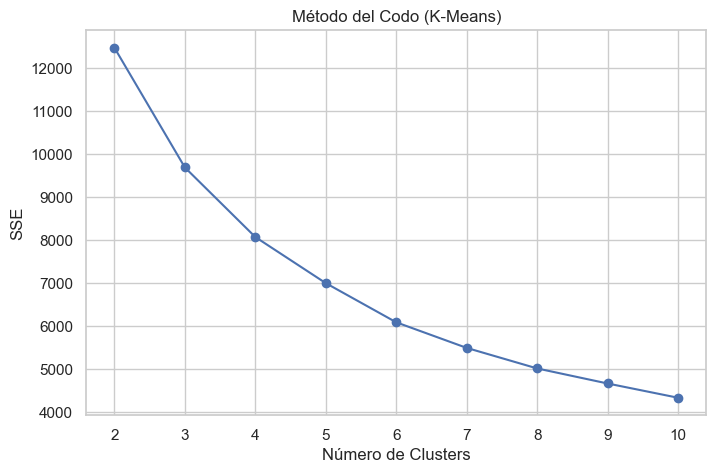

In [215]:
# Seleccionar las variables relevantes para clustering
# Estas variables son transformadas y normalizadas para evitar sesgos en los algoritmos
variables_clustering = ['Recencia', 'Frecuencia_log', 'Monto_Total_log', 
                        'Cantidad_Total_log', 'Monto_Promedio_log']
rfm_clustering_data = rfm_clientes[variables_clustering]

# Escalar las variables para estandarizar los valores
# La estandarización asegura que todas las métricas tengan igual peso
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering_data)

# Determinar el número óptimo de clusters usando el Método del Codo
sse = []  # Lista para almacenar la suma de errores cuadrados
k_values = range(2, 11)  # Evaluar entre 2 y 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)  # Ajustar el modelo K-Means
    sse.append(kmeans.inertia_)  # Almacenar la inercia para cada valor de k

# Visualizar el Método del Codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')  # Gráfico de codo
plt.title('Método del Codo (K-Means)')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()



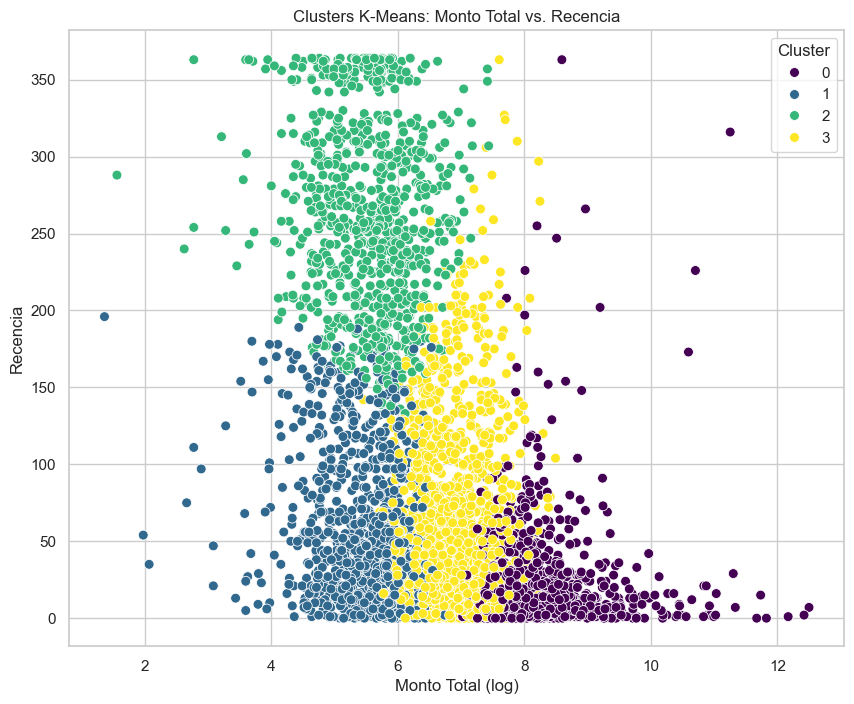

Silhouette Score para K-Means: 0.28


In [216]:
# Elegir el número óptimo de clusters basado en el gráfico del codo
optimal_k = 4 

# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_clientes['Cluster_KMeans'] = kmeans.fit_predict(rfm_scaled)  # Asignar clusters al DataFrame

# Visualización de Clusters K-Means
plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm_clientes, x='Monto_Total_log', y='Recencia', hue='Cluster_KMeans', palette='viridis', s=50)
plt.title('Clusters K-Means: Monto Total vs. Recencia')
plt.xlabel('Monto Total (log)')
plt.ylabel('Recencia')
plt.legend(title='Cluster')
plt.show()

# Calcular el Silhouette Score para K-Means
# Este puntaje evalúa qué tan bien separados están los clusters (1 es el máximo)
silhouette_kmeans = silhouette_score(rfm_scaled, rfm_clientes['Cluster_KMeans'])
print(f"Silhouette Score para K-Means: {silhouette_kmeans:.2f}")


**Un Silhouette Score de 0.28 es bajo, lo que sugiere que los clusters no están bien definidos.**

**Clusters solapados : Las fronteras entre los clusters no son claras.**

**Posible ruido o valores atípicos : Estos pueden estar afectando la calidad del clustering.**

**Conclusión:** El Silhouette Score de 0,28 indica que los clusters pueden ser mejorados ajustando los parámetros, las variables o el número de clusters.


In [217]:
# Resumen descriptivo de los clusters generados por K-Means
cluster_summary_kmeans = rfm_clientes.groupby('Cluster_KMeans').agg(
    Recencia_Promedio=('Recencia', 'mean'),
    Frecuencia_Promedio=('Frecuencia', 'mean'),
    Monto_Total_Promedio=('Monto_Total', 'mean'),
    Clientes=('CustomerID', 'count')
).reset_index()

print("\nResumen de Clusters (K-Means):\n")
cluster_summary_kmeans


Resumen de Clusters (K-Means):



,Cluster_KMeans,Recencia_Promedio,Frecuencia_Promedio,Monto_Total_Promedio,Clientes
0,0,24.797393,12.067536,7208.215900,844
1,1,55.675325,1.733267,270.988953,1001
2,2,259.526316,1.315789,321.571112,836
3,3,58.895421,2.929455,1094.918009,1616


- **Conclusión**

    - **Cluster 0** es el grupo más valioso, compuesto por clientes frecuentes y recientes que generan altos ingresos. Ideal para campañas de fidelización.

    - **Cluster 1 y Cluster 2** contienen clientes menos activos, con bajo gasto. Se pueden diseñar estrategias de reactivación o atraerlos de nuevo.

    - El **cluster 3** representa a clientes activos con gasto intermedio, lo que sugiere un potencial de crecimiento con ofertas específicas.
    
    
### <span style="color:teal">Ahora implementaremos Clustering Jerárquico utilizando el método de aglomeración y dendrogramas para identificar los clusters.</span>

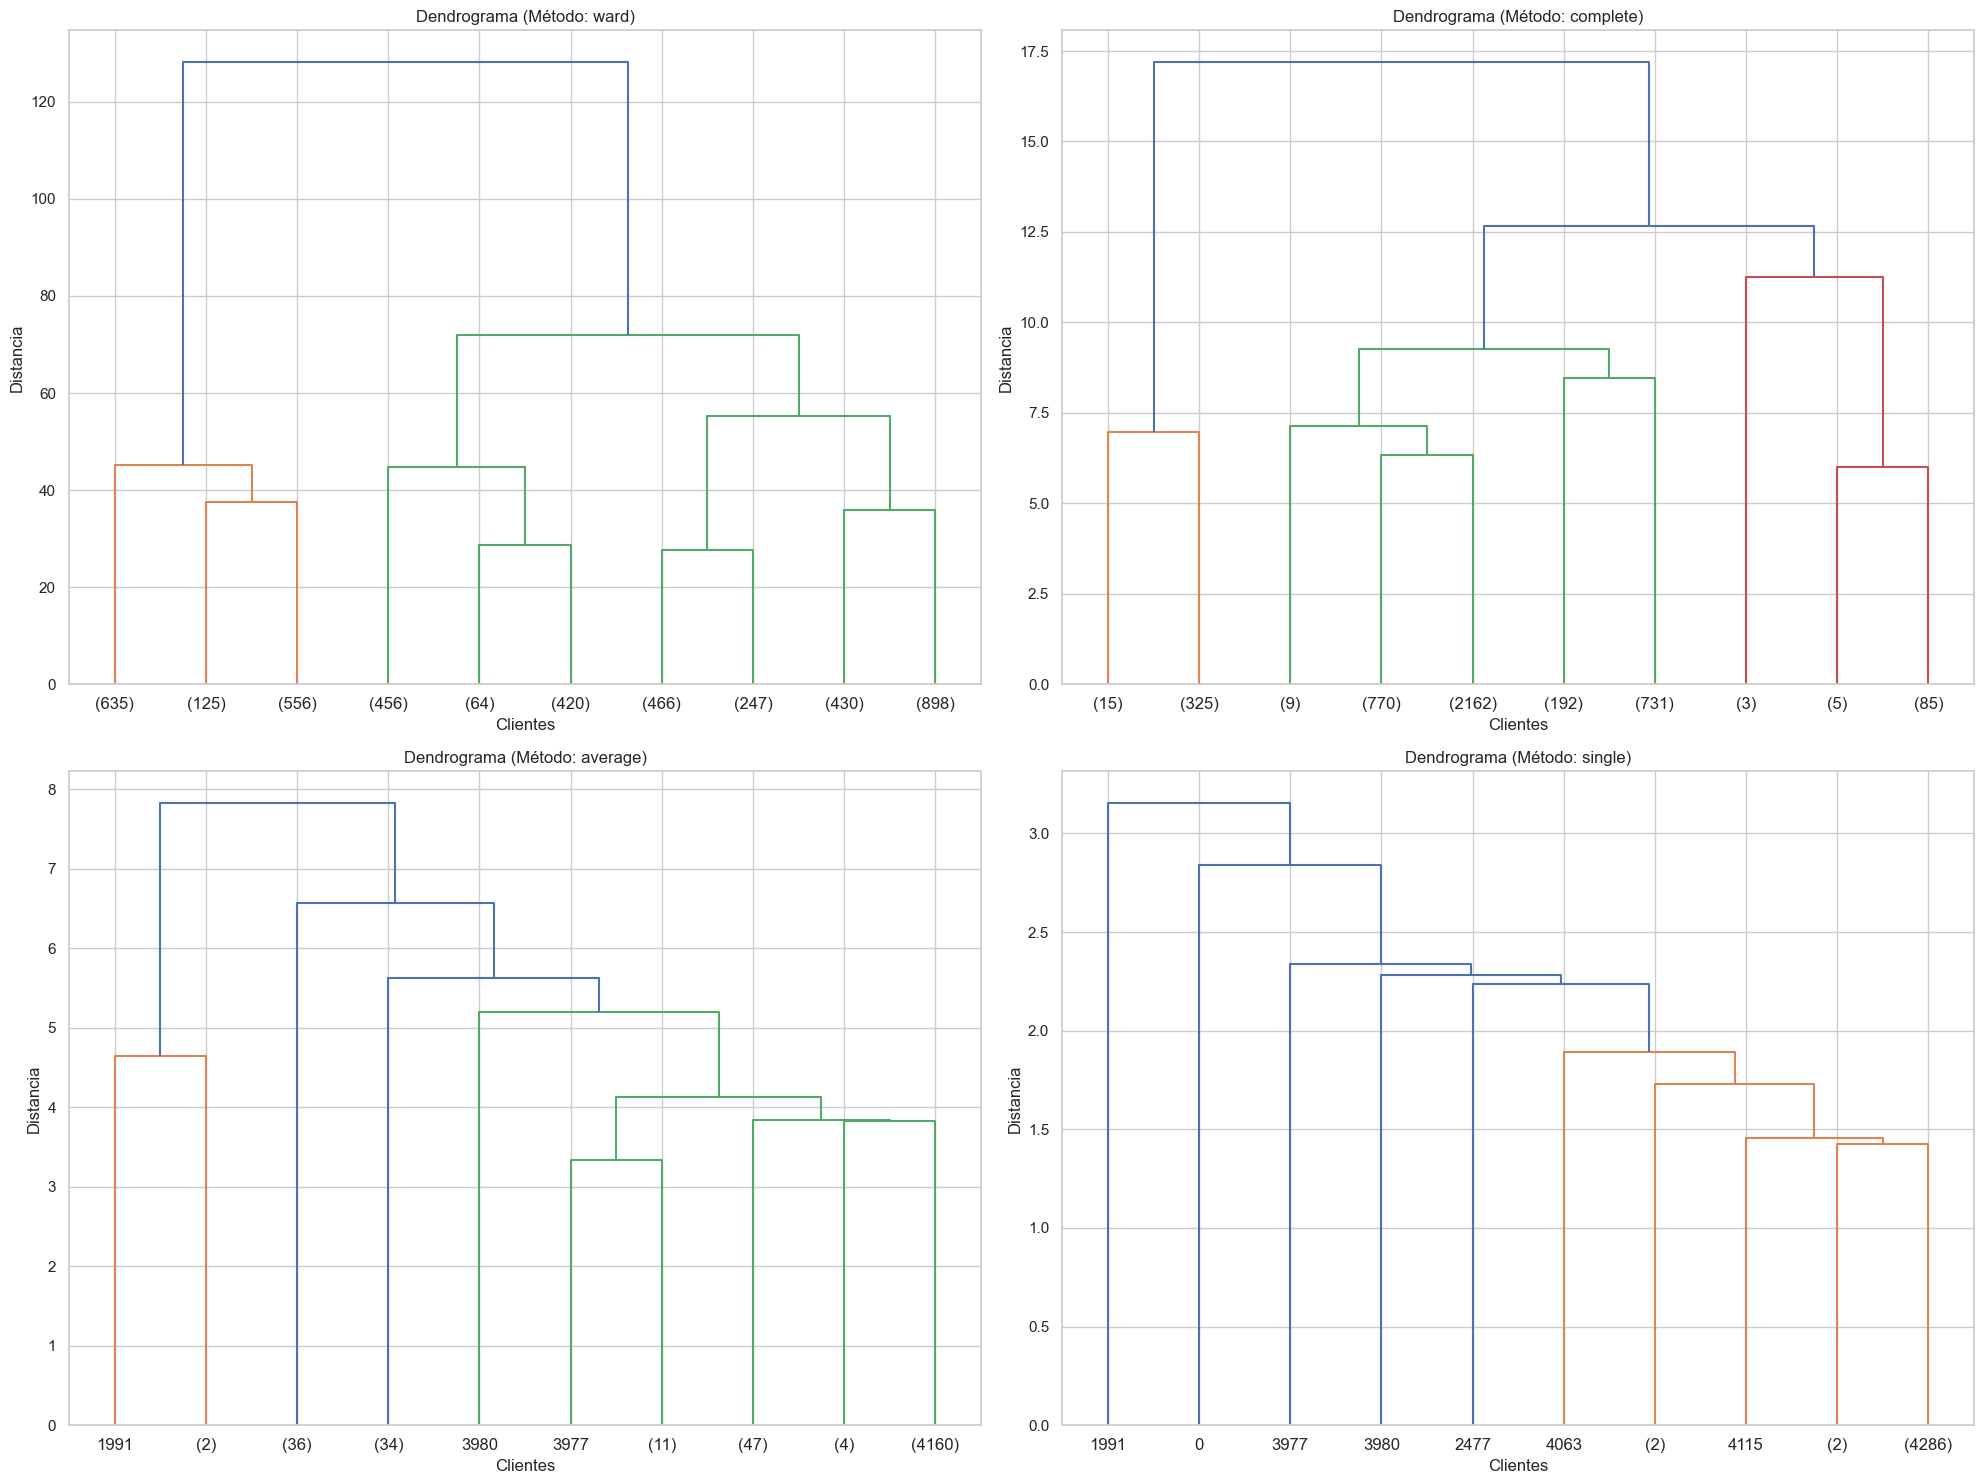

In [218]:
# Definir los métodos de enlace
linkage_methods = ['ward', 'complete', 'average', 'single']

# Generar dendrogramas para cada método de enlace
plt.figure(figsize=(20, 15))  
for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)  
    linkage_matrix = linkage(rfm_scaled, method=method)  # Generar la matriz de enlace
    dendrogram(linkage_matrix, truncate_mode='lastp', p=10, show_leaf_counts=True)  # Generar el dendrograma
    plt.title(f'Dendrograma (Método: {method})')  # Título del dendrograma
    plt.xlabel('Clientes')
    plt.ylabel('Distancia')

plt.tight_layout()  # Ajustar los espacios entre los subplots
plt.show()

# Seleccionar un método de enlace y determinar los clusters
# Elegir el método basado en la observación de los dendrogramas
selected_method = 'ward'  # Se puede ambiar según el dendrograma que mejor represente la estructura
linkage_matrix = linkage(rfm_scaled, method=selected_method)

# Determinar el número de clusters basándonos en la distancia
optimal_distance = 15  
rfm_clientes['Cluster_Hierarchical'] = fcluster(linkage_matrix, t=optimal_distance, criterion='distance')



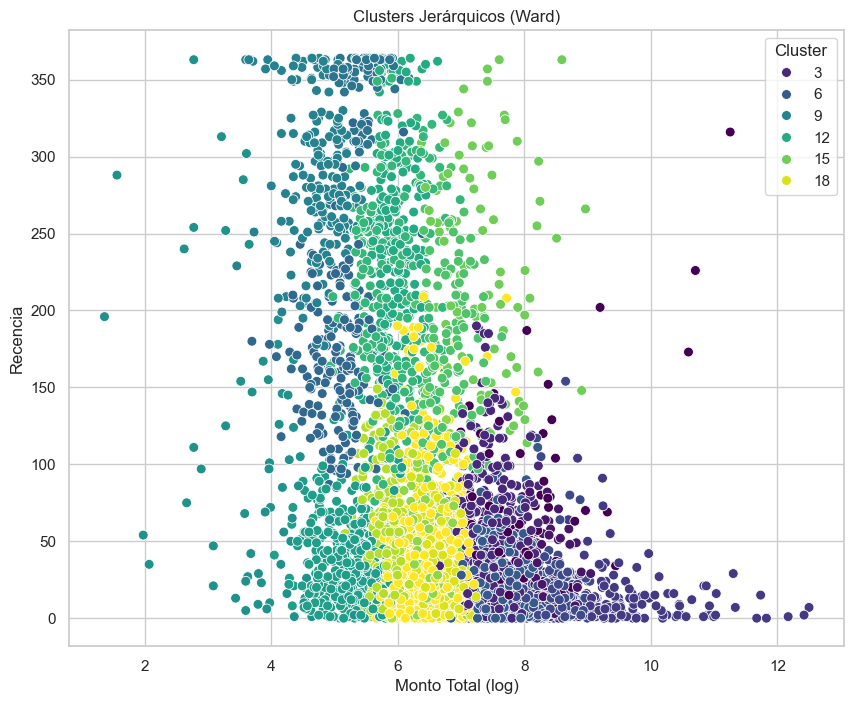

Silhouette Score para Clustering Jerárquico (Ward): 0.17


In [219]:
# Visualizar los clusters resultantes (usando las dimensiones principales)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=rfm_clientes, x='Monto_Total_log', y='Recencia', hue='Cluster_Hierarchical', palette='viridis', s=50)
plt.title(f'Clusters Jerárquicos ({selected_method.capitalize()})')
plt.xlabel('Monto Total (log)')
plt.ylabel('Recencia')
plt.legend(title='Cluster')
plt.show()

# Calcular el Silhouette Score para el clustering jerárquico
from sklearn.metrics import silhouette_score
silhouette_hierarchical = silhouette_score(rfm_scaled, rfm_clientes['Cluster_Hierarchical'])
print(f"Silhouette Score para Clustering Jerárquico ({selected_method.capitalize()}): {silhouette_hierarchical:.2f}")


**Un Silhouette Score de 0.17 indica que la calidad del clustering es baja , y los clusters no están bien definidos ni separados claramente.**

**Los clusters están demasiado cerca unos de otros, lo que genera confusión en las asignaciones. Esto indica una posible falta de estructura clara en los datos.**

In [220]:
# Resumen descriptivo por cluster
cluster_summary_hierarchical = rfm_clientes.groupby('Cluster_Hierarchical').agg(
    Recencia_Promedio=('Recencia', 'mean'),
    Frecuencia_Promedio=('Frecuencia', 'mean'),
    Monto_Total_Promedio=('Monto_Total', 'mean'),
    Clientes=('CustomerID', 'count')
).reset_index()

print("\nResumen de Clusters (Jerárquico):\n")
cluster_summary_hierarchical


Resumen de Clusters (Jerárquico):



,Cluster_Hierarchical,Recencia_Promedio,Frecuencia_Promedio,Monto_Total_Promedio,Clientes
0,1,59.318584,2.079646,4471.643009,113
1,2,26.404762,6.071429,4717.478333,84
2,3,46.484018,3.890411,1851.570342,438
3,4,13.320000,27.608000,27024.366880,125
4,5,15.009901,14.702970,4848.648564,202
5,6,20.864407,8.048023,2219.191836,354
6,7,167.062500,1.380208,179.043281,192
7,8,346.634146,1.000000,241.644024,82
8,9,283.846154,1.027473,121.190275,182
9,10,101.718750,1.531250,55.053437,64


- **Conclusión**

     - **Clientes valiosos y activos - Clústeres 4 y 5:** Clientes recientes, frecuentes y con alto gasto. Merecen mayor atención para fidelización.

    - **Clientes moderados - Clústeres 0, 2 y 3:** Clientes activos, pero menos valiosos. Podrían ser incentivados para aumentar la frecuencia y el gasto.

    - **Clientes inactivos o perdidos - Clústeres 7, 9, 10 y 11:** Clientes con poca actividad reciente y bajo gasto. Posibles candidatos para estrategias de reactivación o baja prioridad.

    - **Clientes descartables - Clúster 8:** Clientes muy inactivos y de muy bajo valor. Podrían ser excluidos de estrategias futuras.


### <span style="color:orange">Evaluación de los clustering</span>


**<span style="color:olive">Evaluación de la calidad del clustering K-Means</span>**

1. **Silhouette Score**: Un valor entre 0.25 y 0.30 indica clusters débiles. Esto sugiere que los clusters formados tienen una separación aceptable, aunque no perfecta. Podría haber solapamiento entre los clusters.

2. **Número de clusters óptimos:** Según el gráfico del codo, se seleccionaron 4 clusters, lo que equilibra la varianza intra-cluster y la separación entre clusters.

**<span style="color:olive">Evaluación de la calidad del clustering Jeránquico</span>**

1. **Silhouette Score:**  Un valor bajo como 0.17 para el método jerárquico (Ward) indica que los clusters tienen una separación baja.

2. **Método de enlace óptimo:** El método Ward parece generar clusters más compactos, por lo que se usó como base para la segmentación.

**<span style="color:purple">Explicación y nombres descriptivos de los segmentos K-Means</span>**

- **K-Means - 4 clusters**


- **Cluster 0: Clientes Premium**

    - **Recencia Promedio:** 24.8 días (clientes recientes).
    - **Frecuencia Promedio:** 12 (muy frecuentes).
    - **Monto Total Promedio:** 7,208.22 (alto gasto).
    - **Clientes:** 844.
    - **Descripción:** Este segmento agrupa a los clientes más valiosos. Son compradores recientes y frecuentes con un gasto elevado.
    - **Estrategia:** Fidelización con ofertas exclusivas o programas VIP.


- **Cluster 1: Nuevos o Ocasionales**

    - **Recencia Promedio:** 55.6 días (menos recientes).
    - **Frecuencia Promedio:** 1.73 (ocasionales).
    - **Monto Total Promedio:** 270.99 (bajo gasto).
    - **Clientes:** 1,001.
    - **Descripción:** Clientes con poca actividad y bajo compromiso.
    - **Estrategia:** Incentivar con promociones de bienvenida o descuentos para aumentar la frecuencia de compra.


- **Cluster 2: Clientes Perdidos**

    - **Recencia Promedio:** 259.5 días (muy antiguos).
    - **Frecuencia Promedio:** 1.31 (muy ocasionales).
    - **Monto Total Promedio:** 321.57 (gasto bajo).
    - **Clientes:** 836.
    - **Descripción:** Clientes que no han comprado en mucho tiempo y tienen baja actividad.
    - **Estrategia:** Campañas de reactivación con descuentos o personalización basada en compras previas.


- **Cluster 3: Activos de Valor Medio**

    - **Recencia Promedio:** 58.8 días (moderadamente recientes).
    - **Frecuencia Promedio:** 2.93 (moderada).
    - **Monto Total Promedio:** 1,094.92 (intermedio).
    - **Clientes:** 1,616.
    - **Descripción:** Clientes activos con un compromiso moderado.
    - **Estrategia:** Incentivar con programas de lealtad para aumentar la frecuencia y el gasto.



**<span style="color:purple">Explicación y nombres descriptivos de los segmentos Jerárquico</span>**


**Jerárquico - 19 clusters**

**Dado el número mayor de clusters, agruparemos segmentos clave**

- **Clientes Premium y Frecuentes (Clusters 4 y 5)**
 
    - **Recencia:** 13-15 días (recientes).
    - **Frecuencia:** Alta (14-27 compras).
    - **Monto Total:** Muy alto (4,848-27,024).
    - **Clientes:** 125-202.
    - **Descripción:** Los clientes más valiosos del negocio, con alto compromiso y gasto significativo.
    - **Estrategia:** Fidelización con programas exclusivos.


- **Clientes Moderados (Clusters 0, 2, y 3)**

    - **Recencia:** Moderada (26-59 días).
    - **Frecuencia:** Moderada (2-6 compras).
    - **Monto Total:** Intermedio (1,851-4,717).
    - **Clientes:** 438-1,616.
    - **Descripción:** Clientes regulares con potencial para aumentar su gasto o frecuencia.
    - **Estrategia:** Incentivar compras repetidas con promociones o cupones.


- **Clientes Perdidos (Clusters 7, 8, y 9)**

    - **Recencia:** Muy alta (167-346 días).
    - **Frecuencia:** Muy baja (1-1.3 compras).
    - **Monto Total:** Bajo (<300).
    - **Clientes:** 82-192.
    - **Descripción:** Clientes con actividad mínima o inactivos.
    - **Estrategia:** Campañas de reactivación o limpieza del listado de clientes.


- **Clientes de Bajo Valor (Cluster 10 y 11)**

    - **Recencia:** Alta (101 días promedio).
    - **Frecuencia:** Baja (1.4-1.5 compras).
    - **Monto Total:** Muy bajo (55-203).
    - **Clientes:** 64-420.
    - **Descripción:** Clientes con baja importancia financiera.
    - **Estrategia:** Enfocar recursos en segmentos más rentables.


**<span style="color:green">Conclusión</span>**

- **K-Means genera clusters más interpretables, con 4 grupos bien definidos. Es más práctico para segmentar clientes y diseñar estrategias.**


- **Jerárquico proporciona un análisis más granular, útil para identificar subgrupos específicos dentro de clientes activos e inactivos.**
